In [1]:
import shapefile #read SHP file

import rasterio #read TIFF file
import rasterio.plot as rplt 

import cv2
from scipy import ndimage as ndi
from skimage import io,img_as_uint
from skimage.morphology import disk, dilation, erosion, remove_small_objects
from skimage.measure import label, regionprops
from skimage.filters import threshold_local
import matplotlib.pyplot as plt

from scipy import optimize
import numpy as np
import math
import pandas as pd

In [2]:
sf = shapefile.Reader(r"D:\Jizhou_UK\DFW\Late\las\DFW_late_mtps.shp",'rb')

shapes = sf.shapes()

list_p = []
num=0
for i in shapes:
    list_p.append(shapes[num].points[0])
    num+=1
    
dataset = rasterio.open(r"D:\Jizhou_UK\DFW\Late\las\190723\DFW_late_190723_chm.tif")

upper_left_x, upper_left_y = (list_p[0][0],list_p[0][1])
upper_left_row, upper_left_col = dataset.index(upper_left_x, upper_left_y)

lower_left_x, lower_left_y = (list_p[1][0],list_p[1][1])
lower_left_row, lower_left_col = dataset.index(lower_left_x, lower_left_y)

upper_right_x, upper_right_y = (list_p[3][0],list_p[3][1])
upper_right_row, upper_right_col = dataset.index(upper_right_x, upper_right_y)

lower_right_x, lower_right_y = (list_p[2][0],list_p[2][1])
lower_right_row, lower_right_col = dataset.index(lower_right_x, lower_right_y)

print(upper_left_row, upper_left_col, lower_left_row, lower_left_col, upper_right_row, upper_right_col, 
      lower_right_row, lower_right_col)

-1 212 3387 0 440 7163 3830 6946


In [3]:
columns_1 = np.int(math.sqrt((upper_left_row-lower_left_row)**2
                              + (upper_left_col-lower_left_col)**2))
columns_2 = np.int(math.sqrt((upper_right_row-lower_right_row)**2
                              + (upper_right_col-lower_right_col)**2))
columns = np.max((columns_1,columns_2))

rows_1 = np.int(math.sqrt((upper_left_row-upper_right_row)**2
                           + (upper_left_col-upper_right_col)**2))
rows_2 = np.int(math.sqrt((lower_left_row-lower_right_row)**2
                           + (lower_left_col-lower_right_col)**2))
rows = np.max((rows_1,rows_2))
print(rows,columns)

6964 3396


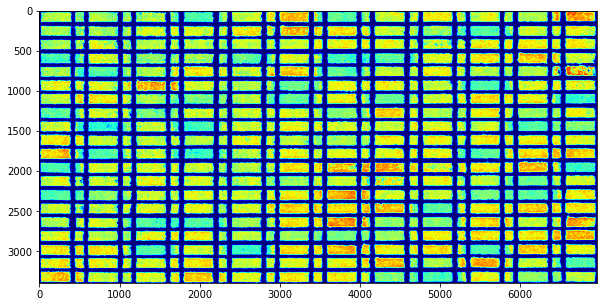

In [4]:
img_tif = io.imread(r"D:\Jizhou_UK\DFW\Late\las\190723\DFW_late_190723_chm.tif")

pts1 = np.float32([[upper_left_col,upper_left_row],[upper_right_col,upper_right_row],[lower_left_col,lower_left_row],
                   [lower_right_col,lower_right_row]])
pts2 = np.float32([[0,0],[rows,0],[0,columns],[rows,columns]]) #The image size after perspective transformation is determined according to the aspect ratio of the actual field
M_PT = cv2.getPerspectiveTransform(pts1,pts2)

dst_PT = cv2.warpPerspective(img_tif,M_PT,(rows,columns))

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(dst_PT,cmap='jet',vmin = 0, vmax = 1)

31518.0
240


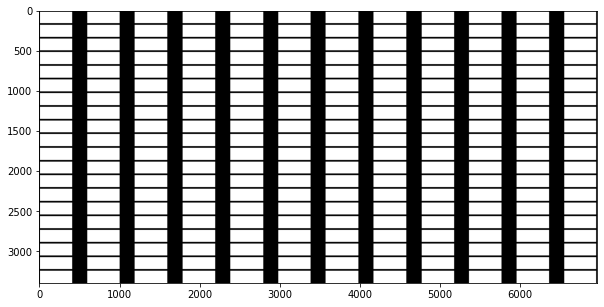

In [5]:
mask_line = io.imread(r"D:\Jizhou_UK\DFW\Late\las\mask_2.png")
selem = disk(7)
Grid_Image = dilation(mask_line, selem)

Grid_Segment = np.logical_not(Grid_Image) 
Grid_Segment_Refine = erosion(Grid_Segment, disk(3))

list_bbox_area = []
Labelled_Plot_Img_o, num_features_o = ndi.measurements.label(Grid_Segment_Refine)
for region in regionprops(Labelled_Plot_Img_o):
    list_bbox_area.append(region.area)
    
re_area = np.max(list_bbox_area)*0.5
print(re_area)

Grid_Segment_Refine = remove_small_objects(Grid_Segment_Refine, re_area)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(Grid_Segment_Refine, cmap=plt.cm.gray)

Labelled_Plot_Img, num_features = ndi.measurements.label(Grid_Segment_Refine)
print(num_features)

In [6]:
list_cencoor = list()
Centroid_coordinates = list()
# 3DCI
FT_area_index = []
curvature_index = []
canopy_cover_index = []

for region in regionprops(Labelled_Plot_Img):
    minr, minc, maxr, maxc = region.bbox
    
    list_cencoor.append(region.centroid[1])
    Centroid_coordinates.append(region.centroid)
    roi=dst_PT[int(region.centroid[0])-40:int(region.centroid[0])+40,
               int(region.centroid[1])-150:int(region.centroid[1])+150]
    # fourier transform
    # spectrogram
    fft2 = np.fft.fft2(roi)
    shift2center = np.fft.fftshift(fft2)
    
    # log transform
    log_fft2 = np.log(1 + np.abs(fft2))
    log_shift2center = np.log(1 + np.abs(shift2center))
    X = []
    Y = []
    for j in range(log_shift2center.shape[1]):
        i = int(log_shift2center.shape[0]/log_shift2center.shape[1] * j)
        x = np.sqrt(i**2+j**2) - np.sqrt((log_shift2center.shape[0]/2)**2+(log_shift2center.shape[1]/2)**2)
        y = log_shift2center[i,j]
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    # gaussian fitting
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean)/4/stddev)**2)
    popt, pcov = optimize.curve_fit(gaussian, X, Y)
    Y = gaussian(X, *popt)
    # canopy structure index
    FT_area = np.trapz(Y,X)
    FT_area_index.append(FT_area)
    # curvature
    dx_dt = np.gradient(X) # V(x)
    dy_dt = np.gradient(Y) # V(y)
    velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])
    # speed vector
    ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt) # speed
    tangent = np.array([1/ds_dt] * 2).transpose() * velocity # the unit tangent vector
    # take the derivative of the tangent vector and divide by its length to get the unit normal vector
    tangent_x = tangent[:, 0]
    tangent_y = tangent[:, 1]
    deriv_tangent_x = np.gradient(tangent_x)
    deriv_tangent_y = np.gradient(tangent_y)
    dT_dt = np.array([ [deriv_tangent_x[i], deriv_tangent_y[i]] for i in range(deriv_tangent_x.size)])
    length_dT_dt = np.sqrt(deriv_tangent_x * deriv_tangent_x + deriv_tangent_y * deriv_tangent_y)
    normal = np.array([1/length_dT_dt] * 2).transpose() * dT_dt
    d2s_dt2 = np.gradient(ds_dt) #acceleration
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
    curvature_max = np.max(curvature)
    curvature_index.append(curvature_max)
    # canopy cover
    thresh = threshold_local(roi, block_size = 175)
    mask = roi > thresh
    canopy_area = 0
    label_img = label(mask)
    for region in regionprops(label_img):
        area = region.area
        canopy_area = canopy_area+area
    canopy_cover = canopy_area/(roi.shape[0]*roi.shape[1])
    canopy_cover_index.append(canopy_cover)

In [7]:
rows = np.unique(np.array(Centroid_coordinates)[:,0]).shape[0]
columns = int(len(Centroid_coordinates)/rows)

# rows&columns
row_index=[]
column_index=[]
for i in range(int(rows)):
    for j in range(int(columns)):
        row_index.append(i+1)
        column_index.append(j+1)
        
# Reorder each row
Centroid_coordinates_y_array = np.array(list_cencoor)

FT_area_index_array = np.array(FT_area_index)
curvature_index_array = np.array(curvature_index)
canopy_cover_index_array = np.array(canopy_cover_index)

FT_area_index_new = []
curvature_index_new = []
canopy_cover_index_new= []


for n in range(0, rows):
    #Extracts each row subarray and column coordinate subarray
    sub_array_y = Centroid_coordinates_y_array[n*columns:columns+n*columns]
    sub_array_FT_area_index = FT_area_index_array[n*columns:columns+n*columns]
    sub_array_curvature_index = curvature_index_array[n*columns:columns+n*columns]
    sub_array_canopy_cover_index = canopy_cover_index_array[n*columns:columns+n*columns]
    
    #Sort by column coordinates
    rank = np.argsort(sub_array_y)
    sub_array_FT_area_index = sub_array_FT_area_index[rank]
    sub_array_curvature_index = sub_array_curvature_index[rank]
    sub_array_canopy_cover_index = sub_array_canopy_cover_index[rank]
    
    #Rewrite the new sequential list
    for i in range(0,sub_array_FT_area_index.shape[0]):
        sub_element_FT_area_index = sub_array_FT_area_index[i]
        sub_element_curvature_index = sub_array_curvature_index[i]
        sub_element_canopy_cover_index = sub_array_canopy_cover_index[i]
        
        FT_area_index_new.append(sub_element_FT_area_index)
        curvature_index_new.append(sub_element_curvature_index)
        canopy_cover_index_new.append(sub_element_canopy_cover_index)

In [8]:
dt = pd.DataFrame({'rows':row_index, 'columns':column_index,'Canopy_index':FT_area_index_new,'curvature_index':curvature_index_new,
                   'canopy_cover_index':canopy_cover_index_new,})
dt.to_csv(r"D:\Jizhou_UK\DFW\Late\las\190723\DFW_late_190723_3d_index.csv",encoding="gbk")